# AVISO

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import pyproj
from rasterio.transform import Affine

import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.geodesic as cgeo
crs = ccrs.PlateCarree()
import cmocean.cm as cm

from xgcm import Grid
from xhistogram.xarray import histogram
import warnings
warnings.filterwarnings("ignore")

import os
from glob import glob


import m2lib22.box as box
import m2lib22.aviso as aviso
import m2lib22.cstes as cstes


In [2]:
if True:
    from dask.distributed import Client
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster(cores=14, processes=14) # a tester
    w = cluster.scale(jobs=1)
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()

client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.0.115:8787/status,
Dashboard: http://10.148.0.115:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.0.115:46980,Workers: 0
Dashboard: http://10.148.0.115:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


_________
## Load data

nc_files = box.load_collocalisations(2018, drifter='gps')
#ds = box.build_dataset(nc_files, 10)
ds = box.build_dataset(nc_files[10], chunks=dict(obs=100))
ds

In [3]:
l = cstes.labels[4]
ds_data = xr.open_zarr(cstes.zarr_dir+'/'+l+'.zarr')

In [4]:
ds_data= ds_data.chunk({'obs':500, 'site_obs':-1}).persist()
ds_data

<xarray.Dataset>
Dimensions:                        (obs: 4054, site_obs: 1489, alti_time: 21,
                                    alti_time_mid: 20, box_y: 40, box_x: 80)
Coordinates: (12/19)
    alti_lat                       (obs, alti_time) float64 dask.array<chunksize=(500, 21), meta=np.ndarray>
    alti_lon                       (obs, alti_time) float64 dask.array<chunksize=(500, 21), meta=np.ndarray>
  * alti_time                      (alti_time) int64 0 1 2 3 4 ... 17 18 19 20
    alti_time_                     (obs, alti_time) datetime64[ns] dask.array<chunksize=(500, 21), meta=np.ndarray>
  * alti_time_mid                  (alti_time_mid) float64 0.5 1.5 ... 18.5 19.5
    alti_x                         (obs, alti_time) float64 dask.array<chunksize=(500, 21), meta=np.ndarray>
    ...                             ...
    drifter_time                   (obs, site_obs) datetime64[ns] dask.array<chunksize=(500, 1489), meta=np.ndarray>
    drifter_x                      (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    drifter_y                      (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    lat                            (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    lon                            (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    time                           (obs) datetime64[ns] dask.array<chunksize=(500,), meta=np.ndarray>
Dimensions without coordinates: obs, site_obs
Data variables: (12/61)
    __site_id                      (obs) object dask.array<chunksize=(500,), meta=np.ndarray>
    __site_matchup_indice          (obs) int32 dask.array<chunksize=(500,), meta=np.ndarray>
    __site_name                    (obs) object dask.array<chunksize=(500,), meta=np.ndarray>
    acc_x                          (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    acc_y                          (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    alti___distance                (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    ...                             ...
    drifter_vn                     (obs, site_obs) float32 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    drifter_vx                     (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    drifter_vy                     (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    f                              (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    g_grad_sla                     (obs, alti_time_mid) float64 dask.array<chunksize=(500, 20), meta=np.ndarray>
    g_grad_sla_denoised            (obs, alti_time_mid) float64 dask.array<chunksize=(500, 20), meta=np.ndarray>
Attributes:
    __id:                   SASSA-L3-SLA-Sentinel-3_A__argos
    __time_coverage_end:    2017-01-01T00:00:00
    __time_coverage_start:  2016-12-01T00:00:00

---

# load and interpolate aviso

### Load aviso data for a single collocation

In [5]:
ds_aviso = aviso.load_aviso(ds_data.time[10].values, (0,1), suffix="aviso_") #aviso on five days
ds_aviso

<xarray.Dataset>
Dimensions:         (aviso_time: 1, aviso_lat: 720, nv: 2, aviso_lon: 1440)
Coordinates:
  * aviso_time      (aviso_time) datetime64[ns] 2018-01-28
  * aviso_lat       (aviso_lat) float32 -89.88 -89.62 -89.38 ... 89.62 89.88
  * aviso_lon       (aviso_lon) float32 -179.9 -179.6 -179.4 ... 179.6 179.9
  * nv              (nv) int32 0 1
Data variables: (12/14)
    crs             (aviso_time) int32 -2147483647
    lat_bnds        (aviso_time, aviso_lat, nv) float32 -90.0 -89.75 ... 90.0
    lon_bnds        (aviso_time, aviso_lon, nv) float32 -180.0 -179.8 ... 180.0
    sla             (aviso_time, aviso_lat, aviso_lon) float64 nan nan ... nan
    err_sla         (aviso_time, aviso_lat, aviso_lon) float64 nan nan ... nan
    ugosa           (aviso_time, aviso_lat, aviso_lon) float64 nan nan ... nan
    ...              ...
    err_vgosa       (aviso_time, aviso_lat, aviso_lon) float64 nan nan ... nan
    adt             (aviso_time, aviso_lat, aviso_lon) float64 nan nan ... nan
    ugos            (aviso_time, aviso_lat, aviso_lon) float64 nan nan ... nan
    vgos            (aviso_time, aviso_lat, aviso_lon) float64 nan nan ... nan
    flag_ice        (aviso_time, aviso_lat, aviso_lon) float64 nan nan ... nan
    tpa_correction  (aviso_time) float64 0.0
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_end:               2018-01-28T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2018-01-27T12:00:00Z
    title:                           DT merged all satellites Global Ocean Gr...

In [ ]:
i=5
ds_aviso = aviso.load_aviso(ds_data.time[i].values, suffix="aviso_") #only at matchup day
print(ds_data.time[i].values)
print(ds_aviso.aviso_time.values)

In [ ]:
ds_aviso.sla.isel(aviso_time=0).plot()

____________
## Compute relevant aviso related variables

In [8]:
def load_aviso(t, dt=None, suffix="aviso_", to_360 = False, rkwargs=None, **kwargs):
    """ Extract AVISO data
    Ref ...
    
    Parameters
    ----------
    t: date-like object
        date for extraction
    dt: tuple, optional
        time interval in days around t
    rkwargs: dict
        dictionary passed to xr.open_dataset
    **kwargs: dict
        passed to sel
    """
    
    t = pd.to_datetime(t)
    if dt is not None:
        t = [t+pd.Timedelta(days=_dt) for _dt in range(*dt)]
    else:
        t = [t]
    if rkwargs is None:
        rkwargs={}
    #LOAD
    D = []
    for _t in t:
        
        files = glob(os.path.join(aviso_dir, f"{_t.year}/{_t.dayofyear:03d}/*.nc"))
        assert len(files)==1, f"error: multiple files at {files}"
        
        if to_360 : # turn erastar to 0-360° if needed
            _ds = (xr.load_dataset(files[0], **rkwargs)
                   #.sel(**kwargs) #in case 180 limit
                      )
            
            assert all(_ds.longitude<=180), 'error : era_star in 0-360° lon coordinates' # verify -180-180° representation for lon coordinates
            _ds = _ds.assign_coords(longitude=cstes.lon_180_to_360(_ds.longitude))
            _ds = _ds.sortby('longitude')
            _ds = _ds.sel(**kwargs) #select data around the colocalisation
            
        else :
            _ds = (xr.load_dataset(files[0], **rkwargs).sel(**kwargs))
                       
            assert all(_ds.longitude<=180), 'error : era_star in 0-360° lon coordinates' # verify -180-180° representation for lon coordinates
        
        #ds = xr.open_dataset(files[0], **rkwargs).sel(**kwargs)
        # load_dataset loads data and close the file immediately while read_dataset is lazy
        # https://docs.xarray.dev/en/latest/generated/xarray.load_dataset.html
        # this choice may be more safe with regards to concurrent readings
        
        D.append(_ds)
    ds = xr.concat(D, dim="time", combine_attrs="drop_conflicts") # drop attributes that vary
    ds = ds.rename(time=suffix+"time", longitude=suffix+"lon", latitude=suffix+"lat")
    return ds

In [31]:
aviso_dir = "/home/ref-cmems-public/tac/sea-level/SEALEVEL_GLO_PHY_L4_MY_008_047/cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D/"
def get_aviso_one_obs(ds_obs, dt=(-1,2), only_matchup_time = True):
    """ load aviso for one collocation """
    dl=0.25
    assert (ds_obs['box_lon']<=180).all(), 'error : ds_obs in 0-360° lon coordinates'
    
    # -180-180 longitude problem
    limite_lon = (ds_obs.drifter_lon>179).any() or (ds_obs.drifter_lon<-179).any() or (ds_obs.box_lon>179).any() or (ds_obs.box_lon<-179).any()
    
    if limite_lon :
        box_lon = cstes.lon_180_to_360(ds_obs.box_lon)
        drifter_lon = cstes.lon_180_to_360(ds_obs.drifter_lon)
        _alti_lon = cstes.lon_180_to_360(ds_obs.alti_lon.isel(alti_time=10))# only matchup

    else : 
        box_lon = ds_obs['box_lon']  
        drifter_lon = ds_obs['drifter_lon'] 
        _alti_lon = ds_obs['alti_lon'].isel(alti_time=10)# only matchup
        
    # matchup site
    site_matchup_indice = int(ds_obs.__site_matchup_indice.values)
    _drifter_lon = drifter_lon.isel(site_obs = site_matchup_indice).values
    _drifter_lat = ds_obs.drifter_lat.isel(site_obs = site_matchup_indice).values
    _drifter_time = ds_obs.drifter_time.isel(site_obs = site_matchup_indice).values
                                         
    #select eras only over the box/drifter trajectory
    lon_min = min(box_lon.min(), drifter_lon.min())
    lon_max = max(box_lon.max(), drifter_lon.max())
    lat_min = min(ds_obs.box_lat.min(), ds_obs.drifter_lat.min())
    lat_max = max(ds_obs.box_lat.max(), ds_obs.drifter_lat.max())
    
    
    
    # load data
    _drop = ['crs','lat_bnds','lon_bnds','ugosa', 'err_ugosa','vgosa',
             'err_vgosa','adt','ugos','vgos','flag_ice','tpa_correction','nv']
    try : 
        ds_aviso = load_aviso(ds_obs.time.values, dt, suffix="aviso_",to_360 = limite_lon,
                          rkwargs={'drop_variables':_drop}, 
                            longitude=np.arange(lon_min-dl,lon_max+dl, dl), 
                           latitude=np.arange(lat_min-dl,lat_max+dl, dl),
                           method='nearest', tolerance=dl)# aviso sla and err_sla around matchup_time
    except : 
        assert False, (ds_obs.__site_id.values, ds_obs.time.values)
    
    # interplate over the trajectoire
    ds_traj = ds_aviso.interp(aviso_time = ds_obs.drifter_time, aviso_lon = drifter_lon, 
                             aviso_lat = ds_obs.drifter_lat).rename({v: "aviso_traj_"+v for v in ds_aviso}).drop(['drifter_lon', 'drifter_lat','aviso_time','aviso_lon','aviso_lat','lat','lon','time'])

    
    #interpolate on the box
    if only_matchup_time : 
        ds_box = ds_aviso.interp(aviso_time = _drifter_time, aviso_lon = box_lon, aviso_lat = ds_obs.box_lat).rename({v: "aviso_box_"+v for v in ds_aviso}).drop(['aviso_lon','aviso_lat','aviso_time','lat','lon','time'])
    else : 
        ds_box = ds_aviso.interp( aviso_lon = box_lon, aviso_lat = ds_obs.box_lat).rename({v: "aviso_box_"+v for v in ds_aviso}).drop(['aviso_lon','aviso_lat','lat','lon','time'])
    
    # interpolate at drifter matchup position, for all drifter times
    ds_drifter = ds_aviso.interp(aviso_lon = _drifter_lon, aviso_lat = _drifter_lat).drop(['aviso_lon', 'aviso_lat']).rename({v: "aviso_drifter_matchuptemp_"+v for v in ds_aviso})
    
    # at alti matchup
    ds_alti = ds_aviso.interp(aviso_time = ds_obs.alti_time_.isel(alti_time=10), aviso_lon =_alti_lon, aviso_lat = ds_obs.alti_lat.isel(alti_time=10))
    ds_alti = ds_alti.drop(list(ds_alti.coords.keys())).rename({v: "aviso_alti_matchup_"+v for v in ds_aviso})
    
    #gradient
    g=9.81
    try:
        ds_traj['aviso_traj_g_grad_x']= g * ds_traj['aviso_traj_sla'].differentiate('drifter_x')
        ds_traj['aviso_traj_g_grad_y']= g * ds_traj['aviso_traj_sla'].differentiate('drifter_y')
        ds_box['aviso_box_g_grad_x']= g * ds_box['aviso_box_sla'].differentiate('box_x')
        ds_box['aviso_box_g_grad_y']= g * ds_box['aviso_box_sla'].differentiate('box_y')
        
    except : 
        try:
            ds_traj['aviso_traj_g_grad_x']= g * ds_traj['aviso_traj_sla'].compute().differentiate('drifter_x')
            ds_traj['aviso_traj_g_grad_y']= g * ds_traj['aviso_traj_sla'].compute().differentiate('drifter_y')
            ds_box['aviso_box_g_grad_x']= g * ds_box['aviso_box_sla'].compute().differentiate('box_x')
            ds_box['aviso_box_g_grad_y']= g * ds_box['aviso_box_sla'].compute().differentiate('box_y')
        except:
            assert False, 'pb differentiate grad'
    
    if only_matchup_time :
        ds_alti['aviso_alti_matchup_g_grad_x']= ds_box['aviso_box_g_grad_x'].sel(box_x=0, box_y=0)
        ds_alti['aviso_alti_matchup_g_grad_y']= ds_box['aviso_box_g_grad_y'].sel(box_x=0, box_y=0)
    else : 
        ds_alti['aviso_alti_matchup_g_grad_x']= ds_box['aviso_box_g_grad_x'].sel(box_x=0, box_y=0).isel(aviso_time = np.where(np.arange(*dt)==0)[0][0])
        ds_alti['aviso_alti_matchup_g_grad_y']= ds_box['aviso_box_g_grad_y'].sel(box_x=0, box_y=0).isel(aviso_time = np.where(np.arange(*dt)==0)[0][0])
        
    ds_traj['aviso_drifter_matchup_g_grad_x']= ds_traj['aviso_traj_g_grad_x'].isel(site_obs = site_matchup_indice)
    ds_traj['aviso_drifter_matchup_g_grad_y']= ds_traj['aviso_traj_g_grad_y'].isel(site_obs = site_matchup_indice)

    # convert to dataset and massage in order to concatenate properly in get_aviso
    ds = (xr.merge([ds_traj, ds_box, ds_drifter, ds_alti])).reset_index("aviso_time").reset_coords(["drifter_time", "drifter_x", "drifter_y", 'aviso_time_'])
    
    ds['time']=ds_obs.time.drop(['lon', 'lat'])
    
    return ds

def _concat_aviso(ds, dt=(-1,2), only_matchup_time=True):
    """ Load aviso data for multiple collocations and concatenate """
    return xr.concat([get_aviso_one_obs(ds.sel(obs=o), dt, only_matchup_time) for o in ds.obs], 'obs')

def compute_aviso_sla(ds, dt=(-1,2), only_matchup_time = True):
    """
    https://xarray.pydata.org/en/stable/user-guide/dask.html
    Parameters
    ----------
    ds: xr.Dataset
        Input collocation dataset
    dt: tuple
        Time offsets compared to the collocation, e.g. if collocation
        is at time t and dt=(-5,5), aviso data will be interpolated on 
        the interval (t-5 days, t+5 days)
        Default is (-1,2)
    only_matchup_time : bool
                        if True return aviso_sla, aviso_g_grad_x/y on the box only for the drifter matchup time
                        if False return it for all aviso time over the dt period

    Return
    ------
    ds: xr.Dataset
        Dataset containing relevant aviso data

    """
    # build template
    template = _concat_aviso(ds.isel(obs=slice(0,2)), dt=dt, only_matchup_time=only_matchup_time)
    
    # broad cast along obs dimension
    template, _ = xr.broadcast(template.isel(obs=0).chunk(), 
                               ds,
                               exclude=[ "aviso_time", "alti_time", "alti_time_mid", "site_obs", "box_x", "box_y",],
                              )
    
    # massage further and unify chunks
    template = (xr.merge([template, ds.drop(["lon", "lat", "time","drifter_lon","drifter_lat","drifter_x","drifter_y", "drifter_time",])])
             .unify_chunks()[list(template.keys())])

    # dimension order is not consistent with that of exiting from map_blocks for some reason
    dims = ["obs", "aviso_time", "box_y", "box_x", "site_obs"]    
    
    template = template.transpose(*dims)#.set_coords(["drifter_time", "drifter_x","drifter_y"])
   
    # actually perform the calculation
    ds_aviso = xr.map_blocks(_concat_aviso, ds, kwargs=dict(dt=dt, only_matchup_time=only_matchup_time), template=template)
    ds_aviso = ds_aviso.set_coords(["time", 'aviso_time_'])# coordinate for obs dimension

    return ds_aviso

In [28]:
dt=(-1,3)
np.where(np.arange(*dt)==0)[0][0]

1

### One observation dataset

In [32]:
ds_aviso_obs = get_aviso_one_obs(ds_data.isel(obs=0),dt=(-1,2), only_matchup_time = False)
ds_aviso_obs

<xarray.Dataset>
Dimensions:                            (site_obs: 1489, aviso_time: 3,
                                        box_y: 40, box_x: 80)
Coordinates:
  * box_x                              (box_x) float64 -2e+05 ... 1.95e+05
  * box_y                              (box_y) float64 -1e+05 ... 9.5e+04
Dimensions without coordinates: site_obs, aviso_time
Data variables: (12/21)
    aviso_traj_sla                     (site_obs) float64 nan nan ... nan nan
    aviso_traj_err_sla                 (site_obs) float64 nan nan ... nan nan
    drifter_time                       (site_obs) datetime64[ns] dask.array<chunksize=(1489,), meta=np.ndarray>
    drifter_x                          (site_obs) float64 dask.array<chunksize=(1489,), meta=np.ndarray>
    drifter_y                          (site_obs) float64 dask.array<chunksize=(1489,), meta=np.ndarray>
    aviso_traj_g_grad_x                (site_obs) float64 nan nan ... nan nan
    ...                                 ...
    aviso_alti_matchup_sla             float64 0.1697
    aviso_alti_matchup_err_sla         float64 0.009418
    aviso_alti_matchup_g_grad_x        float64 -1.528e-05
    aviso_alti_matchup_g_grad_y        float64 1.048e-05
    aviso_time_                        (aviso_time) datetime64[ns] 2016-11-30...
    time                               datetime64[ns] dask.array<chunksize=(), meta=np.ndarray>
Attributes: (12/38)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    ssalto_duacs_comment:            The reference mission used for the altim...
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_resolution:        P1D
    title:                           DT merged all satellites Global Ocean Gr...

In [33]:
ds_compute = compute_aviso_sla(ds_data.isel(obs=slice(0,10)), dt=(-1,2), only_matchup_time = True)

In [14]:
ds_compute

<xarray.Dataset>
Dimensions:                    (box_x: 80, box_y: 40, obs: 10, site_obs: 1489,
                                aviso_time: 3)
Coordinates:
  * box_x                      (box_x) float64 -2e+05 -1.95e+05 ... 1.95e+05
  * box_y                      (box_y) float64 -1e+05 -9.5e+04 ... 9e+04 9.5e+04
    aviso_time_                (obs, aviso_time) datetime64[ns] dask.array<chunksize=(10, 3), meta=np.ndarray>
    time                       (obs) datetime64[ns] dask.array<chunksize=(10,), meta=np.ndarray>
Dimensions without coordinates: obs, site_obs, aviso_time
Data variables: (12/17)
    traj_sla                   (obs, site_obs) float64 dask.array<chunksize=(10, 1489), meta=np.ndarray>
    traj_err_sla               (obs, site_obs) float64 dask.array<chunksize=(10, 1489), meta=np.ndarray>
    drifter_time               (obs, site_obs) datetime64[ns] dask.array<chunksize=(10, 1489), meta=np.ndarray>
    drifter_x                  (obs, site_obs) float64 dask.array<chunksize=(10, 1489), meta=np.ndarray>
    drifter_y                  (obs, site_obs) float64 dask.array<chunksize=(10, 1489), meta=np.ndarray>
    traj_g_grad_sla_x          (obs, site_obs) float64 dask.array<chunksize=(10, 1489), meta=np.ndarray>
    ...                         ...
    drifter_matchup_sla        (obs, aviso_time) float64 dask.array<chunksize=(10, 3), meta=np.ndarray>
    drifter_matchup_err_sla    (obs, aviso_time) float64 dask.array<chunksize=(10, 3), meta=np.ndarray>
    alti_matchup_sla           (obs) float64 dask.array<chunksize=(10,), meta=np.ndarray>
    alti_matchup_err_sla       (obs) float64 dask.array<chunksize=(10,), meta=np.ndarray>
    alti_matchup_g_grad_sla_x  (obs) float64 dask.array<chunksize=(10,), meta=np.ndarray>
    alti_matchup_g_grad_sla_y  (obs) float64 dask.array<chunksize=(10,), meta=np.ndarray>
Attributes: (12/38)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    ssalto_duacs_comment:            The reference mission used for the altim...
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_resolution:        P1D
    title:                           DT merged all satellites Global Ocean Gr...

### Compute dataset

In [33]:
ds_aviso = compute_aviso_sla(ds_data.isel(obs=slice(0,500)).chunk({'obs':50}), dt=(-1,2))

In [34]:
ds_aviso

<xarray.Dataset>
Dimensions:                         (box_x: 80, box_y: 40, obs: 500)
Coordinates:
  * box_x                           (box_x) float64 -2e+05 ... 1.95e+05
  * box_y                           (box_y) float64 -1e+05 -9.5e+04 ... 9.5e+04
    time                            (obs) datetime64[ns] dask.array<chunksize=(50,), meta=np.ndarray>
Dimensions without coordinates: obs
Data variables:
    aviso_sla                       (obs, box_y, box_x) float64 dask.array<chunksize=(50, 40, 80), meta=np.ndarray>
    aviso_err_sla                   (obs, box_y, box_x) float64 dask.array<chunksize=(50, 40, 80), meta=np.ndarray>
    aviso_g_grad_x                  (obs, box_y, box_x) float64 dask.array<chunksize=(50, 40, 80), meta=np.ndarray>
    aviso_g_grad_y                  (obs, box_y, box_x) float64 dask.array<chunksize=(50, 40, 80), meta=np.ndarray>
    aviso_drifter_matchup_sla       (obs) float64 dask.array<chunksize=(50,), meta=np.ndarray>
    aviso_drifter_matchup_g_grad_x  (obs) float64 dask.array<chunksize=(50,), meta=np.ndarray>
    aviso_drifter_matchup_g_grad_y  (obs) float64 dask.array<chunksize=(50,), meta=np.ndarray>
    aviso_alti_matchup_sla          (obs) float64 dask.array<chunksize=(50,), meta=np.ndarray>
    aviso_alti_matchup_g_grad_x     (obs) float64 dask.array<chunksize=(50,), meta=np.ndarray>
    aviso_alti_matchup_g_grad_y     (obs) float64 dask.array<chunksize=(50,), meta=np.ndarray>

In [35]:
aviso_sla = ds_aviso.isel(obs=0).aviso_sla.compute()

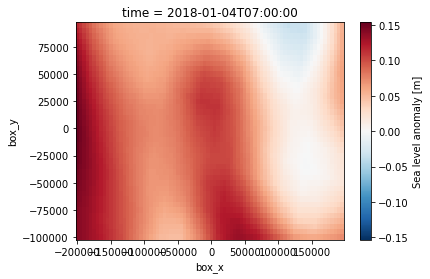

In [36]:
aviso_sla.plot()

### From aviso lib
#### Only matchup time

In [11]:
ds_aviso = aviso.compute_aviso_sla(ds_data.isel(obs=slice(0,500)).chunk({'obs':50}), dt=(-1,2))

In [12]:
aviso_sla = ds_aviso.isel(obs=0).aviso_sla.compute()

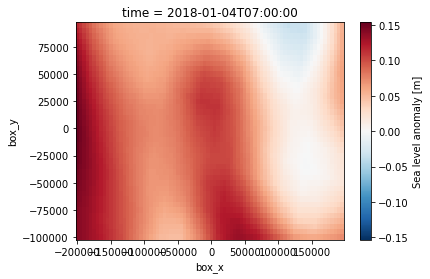

In [13]:
aviso_sla.plot()

#### Several times

In [8]:
ds_box = aviso.get_aviso_one_obs(ds_data.isel(obs=0), dt=(-1,2), only_matchup_time = False).persist()

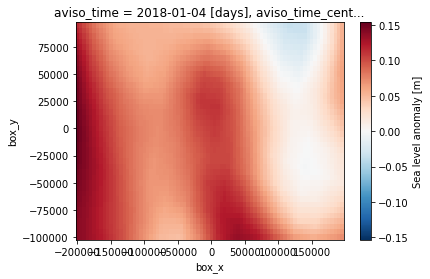

In [15]:
ds_box.where(ds_box.aviso_time_centered == 0, drop=True).aviso_sla.plot()

### Verify interpolation

In [ ]:
ds_aviso.isel(obs=0).aviso_drifter_matchup_sla.compute()

In [55]:
test = ds_aviso.isel(obs=0).set_index({"aviso_time":"aviso_dates"}).compute()
test

<xarray.Dataset>
Dimensions:                         (box_x: 80, box_y: 40, aviso_time: 3)
Coordinates:
  * box_x                           (box_x) float64 -2e+05 ... 1.95e+05
  * box_y                           (box_y) float64 -1e+05 -9.5e+04 ... 9.5e+04
  * aviso_time                      (aviso_time) datetime64[ns] 2018-01-03 .....
    time                            datetime64[ns] 2018-01-04T07:00:00
Data variables:
    aviso_sla                       (aviso_time, box_y, box_x) float64 0.1393...
    aviso_g_grad_x                  (aviso_time, box_y, box_x) float64 -4.102...
    aviso_g_grad_y                  (aviso_time, box_y, box_x) float64 7.106e...
    aviso_drifter_matchup_sla       float64 0.1095
    aviso_drifter_matchup_g_grad_x  float64 -7.911e-07
    aviso_drifter_matchup_g_grad_y  float64 -2.798e-06
    aviso_alti_matchup_sla          float64 0.1067
    aviso_alti_matchup_g_grad_x     float64 2.688e-06
    aviso_alti_matchup_g_grad_y     float64 1.727e-06

In [61]:
ds_matchup = ds_data.isel(obs=0).isel(site_obs=ds_data.isel(obs=0).__site_matchup_indice.compute(), alti_time=10, alti_time_mid=10)
ds_matchup.drifter_time.values

numpy.datetime64('2018-01-04T07:00:00.000000000')

In [57]:
interp_xy_drifter = test.aviso_sla.interp(box_x = ds_matchup.drifter_x.values, box_y = ds_matchup.drifter_y.values)
interp_xy_drifter                                                    

<xarray.DataArray 'aviso_sla' (aviso_time: 3)>
array([0.10750108, 0.109115  , 0.1102937 ])
Coordinates:
  * aviso_time  (aviso_time) datetime64[ns] 2018-01-03 2018-01-04 2018-01-05
    time        datetime64[ns] 2018-01-04T07:00:00
    box_x       float64 -4.632e+03
    box_y       float64 2.738e+04
Attributes:
    ancillary_variables:  err_sla
    comment:              The sea level anomaly is the sea surface height abo...
    grid_mapping:         crs
    long_name:            Sea level anomaly
    standard_name:        sea_surface_height_above_sea_level
    units:                m

In [60]:
interp_xytime = interp_xy_drifter.interp(aviso_time = ds_matchup.drifter_time.values)
interp_xytime

<xarray.DataArray 'aviso_sla' ()>
array(0.10945879)
Coordinates:
    time        datetime64[ns] 2018-01-04T07:00:00
    box_x       float64 -4.632e+03
    box_y       float64 2.738e+04
    aviso_time  datetime64[ns] 2018-01-04T07:00:00
Attributes:
    ancillary_variables:  err_sla
    comment:              The sea level anomaly is the sea surface height abo...
    grid_mapping:         crs
    long_name:            Sea level anomaly
    standard_name:        sea_surface_height_above_sea_level
    units:                m

---

In [162]:
cluster.close()